In [68]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy import stats, integrate
from scipy.signal import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables as tb

# Functions

In [176]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    N = np.trapz(gaussian, x=np.sort(x)) or 1.
    
    return (a/N)*gaussian

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def dirac(x, x0):
    return np.where((x - x0) == 0, 1, 0)

def EL_yield(E, p, d):
    # E[kV/cm] electric field 
    # p[bar] pressure
    # d[cm] average absorption depth
    return (140*E/p - 116)*d*p # [photons/e⁻]


# Global parameters

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

In [4]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

In [5]:
dt = 1e3 # [ns] = 1us

v_d = 967.99*1e-6 # [mm/ns] = 967.99 [um/us] Drift velocity
Xe_ion = 12.13*1e-6 # [MeV] Xe ionization potential (https://www.nuclear-power.com/xenon-affinity-electronegativity-ionization/)


d = 0.5 # [cm] average absorption depth (https://arxiv.org/pdf/1202.0721.pdf)
p = 15 # [bar] pressure
E = 3*p # [kV/cm] electric field (we ussually get E/p, so we define E in terms of p) (https://arxiv.org/pdf/1202.0721.pdf)
V = E*d # [kV] voltage

# EL_gain = 75 # [photons/e⁻] optical gain (https://iopscience.iop.org/article/10.1088/1748-0221/10/03/P03025/pdf)
# EL_gain = 700 # [photons/e⁻] optical gain (Francesc)
# EL_gain = 2500 # [photons/e⁻] optical gain (https://arxiv.org/pdf/1202.0721.pdf)
# EL_gain = EL_yield(E, p, d) # [photons/e⁻] optical gain (https://arxiv.org/pdf/physics/0702142.pdf)
# EL_gain = 140*V # [photons/e⁻] optical gain (https://arxiv.org/pdf/physics/0702142.pdf)
EL_gain = [500, 1000, 1500, 2000] # [photons/e⁻] optical gain 
print('EL_gain = ', EL_gain)

# e_lt = 16e5 # [ns] electron lifetime
e_lt = 10e6 # [ns] = 10 [ms] electron lifetime
# recombi = 0.026 # recombination factor (https://iopscience.iop.org/article/10.1088/1748-0221/10/03/P03025/pdf)
recombi = 0. # recombination factor (Ander)

difusion_factor = 0.3 # [mm] difusion factor (Ander)

z_max = 1.5e3 # [mm] Detector length/2
z_min = -z_max # symmetric detector

EL_gain =  [500, 1000, 1500, 2000]


# Data

## Units are fundamental units used in Geant4, ie:

### Length [L]: mm (milimeter)
### Time [T]: ns (nanosecond)
### Energy [E]: MeV (megaelectronvolt)


In [6]:
path = '/home/investigator/mariandbt/nexus/'

filename = os.path.join(path, "Xe_tank_bb0nu.next.h5")

In [7]:
# inside a .h5 file there are several objects, let's see which data-set (dst) we want
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/nexus/Xe_tank_bb0nu.next.h5 (File) ''
Last modif.: '2023-03-27T15:22:22+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(36,)) ''
/MC/hits (Table(1499311,)) ''
/MC/particles (Table(317632,)) ''
/MC/sns_positions (Table(0,)) ''
/MC/sns_response (Table(0,)) ''



In [8]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
data = pd.read_hdf(filename, "/MC/hits")
# dst = pd.read_hdf(filename, "/MC/hits").groupby("event_id").get_group(event_id)

In [9]:
dst = data.copy()

# Electron distribution on time

## Number of events

In [10]:
n_events = len(dst['event_id'].unique())
n_events

10000

## Measurement time = hit time + drift time + difusion

### Drift time

In [ ]:
dst['drift_time'] = (z_max - dst['z'])/(v_d) # [ns]

### Difusion effect: variation of the drift time

Instead of one t_drift for each hit we should have one for each electron given the difusion

In [ ]:
# Example with just 1 event
ev_id = 200
EL_index = 0

In [ ]:
dst_event = dst.loc[(dst['event_id'] == ev_id), :].copy() # faster

hit_time = np.array(dst_event['time']) # [ns]
drift_time = np.array(dst_event['drift_time']) # [ns]
hit_energy = np.array(dst_event['energy']) # [MeV]

#### Number of ionization electrons =  (energy of the hit) / (Xenon ionization energy) 

In [ ]:
n_e_ion = np.floor(hit_energy/Xe_ion) # number of ionization electrons

In [ ]:

mu = 0.
sigma = difusion_factor/np.sqrt(drift_time)
size = n_e_ion

t_difusion = []

for ii in range(len(dst_event)):
    t_difusion.append(np.random.normal(mu, sigma[ii], int(size[ii])))
    

In [ ]:
patata = 9
t_difusion[patata] # this gives me the variation wrt 0 of the t_drift for each electron in hit 'patata'
# for each t_drif(hit) we have N t_dif(electrons)

In [ ]:
travel_time = drift_time + np.array(t_difusion, dtype=object)

measurement_time = np.concatenate( hit_time + travel_time )

# travel_time = np.concatenate(travel_time) # we don't concatenate it before because then the + would be different

measurement_time # we have 1 measurement_time for each event with len(measurement_time) = (n_e in that event)

In [ ]:
travel_time = drift_time + np.array(t_difusion, dtype=object)

(hit_time + travel_time)[0]

#### N_ph/N_e_ion =  (1 - recombination factor) * (lifetime factor)* (EL gain) 

In [ ]:
n_ph = (1 - recombi)*np.exp(-np.concatenate(travel_time)/e_lt)*EL_gain[EL_index] # n_photons resulting of each e⁻

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

no_dif_measurement_time = hit_time + drift_time # to compare the difusion effect
n_ph_no_dif = n_e_ion*(1 - recombi)*np.exp(-drift_time/e_lt)*EL_gain[EL_index]

if (measurement_time.max() - measurement_time.min()) > dt:
    hist_bins = np.arange(measurement_time.min(), measurement_time.max(), dt)
    hist_bins_no_dif = np.arange(no_dif_measurement_time.min(), no_dif_measurement_time.max(), dt)
else:
    hist_bins = np.array([measurement_time.min(), measurement_time.max()])
    hist_bins_no_dif = np.array([no_dif_measurement_time.min(), no_dif_measurement_time.max()])

#     hist_weights = dst_event['n_ph']
hist_weights = n_ph
events, bins = np.histogram(measurement_time, hist_bins, weights = hist_weights);

hist_weights_no_dif = n_ph_no_dif
events_no_dif, bins_no_dif = np.histogram(no_dif_measurement_time, hist_bins_no_dif, 
                                          weights = hist_weights_no_dif);

print('Event time = ', 1e-3*(measurement_time.max() - measurement_time.min()), ' us')

ax.step(bins[:-1], events,label = 'with difusion')
ax.step(bins_no_dif[:-1], events_no_dif, '--', label = 'without difusion')

ax.legend(loc = 'best')

ax.set_xlabel('Time [ns]');
ax.set_ylabel('Photons');

## Total time = initial time + drift time

In [11]:
drift_time = (z_max - dst['z'])/(v_d) # [ns]
dst['drift_time'] = drift_time
dst['tot_time'] = dst['time'] + drift_time

In [50]:

mu = 0.
sigma = np.where(drift_time > 0., difusion_factor/np.sqrt(drift_time), 0.)
size = n_e_ion

dt_difusion = []

for ii in range(len(dst)):
    dt_difusion.append(np.random.normal(mu, sigma[ii], int(size[ii])))
    

/tmp/ipykernel_49159/2650922614.py:2: RuntimeWarning: divide by zero encountered in true_divide
  sigma = np.where(drift_time > 0., difusion_factor/np.sqrt(drift_time), 0.)


In [57]:
np.shape(np.array(dt_difusion, dtype = object))

(59,)

### Number of electrons = (energy deposition)  * (1 - recombination factor) * (lifetime factor)/ (ionization energy Xe)

In [12]:
n_e = np.floor(dst['energy']*(1 - recombi)*np.exp(-dst['drift_time']/e_lt)/Xe_ion)
dst['n_e'] = n_e

### Nph = Ne*(EL gain)

In [13]:
for count, EL_value in enumerate(EL_gain):
    dst['n_ph_'+str(count)] = np.floor(dst['n_e']*EL_value)

### Max S2 signal

In [269]:
dst['measurement_time'] = dst['time'] + dst['drift_time']
stds = np.where(dst['drift_time'] > 0., difusion_factor/np.sqrt(dst['drift_time']), 1e-10)
dst['stds'] = stds

In [271]:
# grouped = dst.groupby('event_id')['measurement_time'].apply(list)
grouped = dst.groupby('event_id')['stds'].apply(list)
# grouped = dst.groupby('event_id')['measurement_time']
len(grouped[5])
grouped

event_id
0       [0.00023637887057225386, 0.0002364652095744890...
1       [0.0015991974508496318, 0.0016284871015794695,...
2       [0.0004852348217901502, 0.0004803787834139341,...
3       [0.0001843831964042356, 0.00018387025781397377...
4       [0.00026584134331451295, 0.0002657996086732406...
5       [0.00018739685113841592, 0.0001877754271000225...
6       [0.000501551359085531, 0.0004999234486377813, ...
7       [0.0002172999010270712, 0.00021717368194650244...
8       [0.00020473492295307736, 0.0002046434676601407...
9       [0.00021091988351010671, 0.0002108539180278642...
                              ...                        
9990    [0.00018329318311220653, 0.0001836577784176484...
9991    [0.00027675314787112276, 0.0002754272149112433...
9992    [0.00018361801912079292, 0.0001835707008764806...
9993    [0.00025696243354435657, 0.0002577946415368714...
9994    [0.0004620800178209219, 0.000450471254596602, ...
9995    [0.0005006142086021509, 0.0005064376202538859,...
9996 

In [ ]:
import numpy as np

# Generate some random data
data = np.random.normal(loc=0, scale=1, size=(1000, 10))

# Calculate the histograms
hists, bin_edges = np.histogram(data, bins=100, density=True)

# Get the maximum values of each histogram
# max_values = np.max(hists, axis=1)

# print(f"Max values of all histograms: {max_values}")

In [291]:
import numpy as np

# Generate some random data
data = np.random.normal(loc=0, scale=1, size=(1000, 10))

# Calculate the histograms for each dataset
hists = np.apply_along_axis(lambda x: np.histogram(x, bins=10, density=True)[0], axis=0, arr=data)

# Get the maximum values of each histogram
max_values = np.max(hists, axis=1)

print(f"Max values of all histograms: {max_values}")


Max values of all histograms: [0.02153904 0.06461712 0.16908978 0.32083702 0.40599076 0.39010496
 0.3133288  0.17410725 0.0717968  0.01986963]


In [290]:
len(hists)
# data

100

In [315]:
import pandas as pd
import numpy as np

# Create a sample dataframe
df = pd.DataFrame({
    'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
    'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
    'C': np.random.randn(8),
    'D': np.random.randn(8)
})

# Group the dataframe by columns A and B
grouped = df.groupby(['A', 'B'])

# Get the mean of the groups
result = grouped.mean()

# Pivot the result so that each group becomes a column
result_pivoted = result.unstack()

# Convert the pivoted result to a numpy matrix
result_matrix = result_pivoted.values

print(result_matrix)


[[-0.41466664  1.17695296 -0.25107164 -0.01161506  0.54645829 -1.29748479]
 [ 0.44553982 -0.85504475 -0.20692494 -0.94811215  0.51538414  1.48370691]]


In [318]:
grouped.apply(list)

A    B    
bar  one      [A, B, C, D]
     three    [A, B, C, D]
     two      [A, B, C, D]
foo  one      [A, B, C, D]
     three    [A, B, C, D]
     two      [A, B, C, D]
dtype: object

In [316]:
result

C         D
A   B                        
bar one   -0.414667 -0.011615
    three  1.176953  0.546458
    two   -0.251072 -1.297485
foo one    0.445540 -0.948112
    three -0.855045  0.515384
    two   -0.206925  1.483707

In [355]:
measurement_time_gg = dst.groupby('event_id')['measurement_time']

In [351]:
measurement_time_gg
np.shape(measurement_time_gg[:, 1])
measurement_time_gg[:, 1]

array([0     1.610739e+06
       1     1.609563e+06
       2     1.609906e+06
       3     1.609685e+06
       4     1.609805e+06
       5     1.610103e+06
       6     1.610488e+06
       7     1.610236e+06
       8     1.610152e+06
       9     1.610136e+06
       10    1.610185e+06
       11    1.610147e+06
       12    1.609995e+06
       13    1.610022e+06
       14    1.610079e+06
       15    1.610147e+06
       16    1.610205e+06
       17    1.610197e+06
       18    1.610202e+06
       19    1.610180e+06
       20    1.610173e+06
       21    1.610186e+06
       22    1.610182e+06
       23    1.610177e+06
       24    1.610181e+06
       25    1.610180e+06
       26    1.619440e+06
       27    1.618856e+06
       28    1.617165e+06
       29    1.629913e+06
       30    1.638328e+06
       31    1.641307e+06
       32    1.638499e+06
       33    1.637800e+06
       34    1.641922e+06
       35    1.641905e+06
       36    1.641954e+06
       37    1.643455e+06
       38   

In [361]:
np.array(measurement_time_gg[3])
# measurement_time_gg

array([2647279.74828052, 2662070.51699831, 2663202.49871692,
       2669795.28283671, 2673484.32020576, 2670564.71430037,
       2671021.49156376, 2673629.64941406, 2673188.03239347,
       2674351.12549008, 2674014.8051855 , 2673390.83383668,
       2674165.51412675, 2673278.48180379, 2674018.60747091,
       2673425.9079763 , 2672928.92319631, 2672533.20173126,
       2672409.61887265, 2672292.34119122, 2672514.41713747,
       2672454.51725896, 2672555.90809402, 2672539.38873317,
       2672489.19869904, 2672467.88709607, 2672509.50285037,
       2672526.52765841, 2672552.2538038 , 2672552.001892  ,
       2672531.69894099, 2672532.07748133, 2672531.0688114 ,
       2672534.8521583 , 2672536.49165977, 2672533.96959868,
       2672533.96963322, 2670999.29727282, 2670975.7160975 ,
       2671008.63078795, 2671006.23543276, 2671010.5236579 ,
       2671043.69031143, 2671061.47180986, 2671074.33495311,
       2671077.61390548, 2671080.26223832, 2671080.51450542,
       2647319.85133299,

In [360]:

# %%timeit

drift_time_gg = dst.groupby('event_id')['drift_time'].apply(list) 
measurement_time_gg = dst.groupby('event_id')['measurement_time'].apply(list)

n_photons_gg = dst.groupby('event_id')['n_ph_'+str(count)].apply(list) 



3.16 s ± 66.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


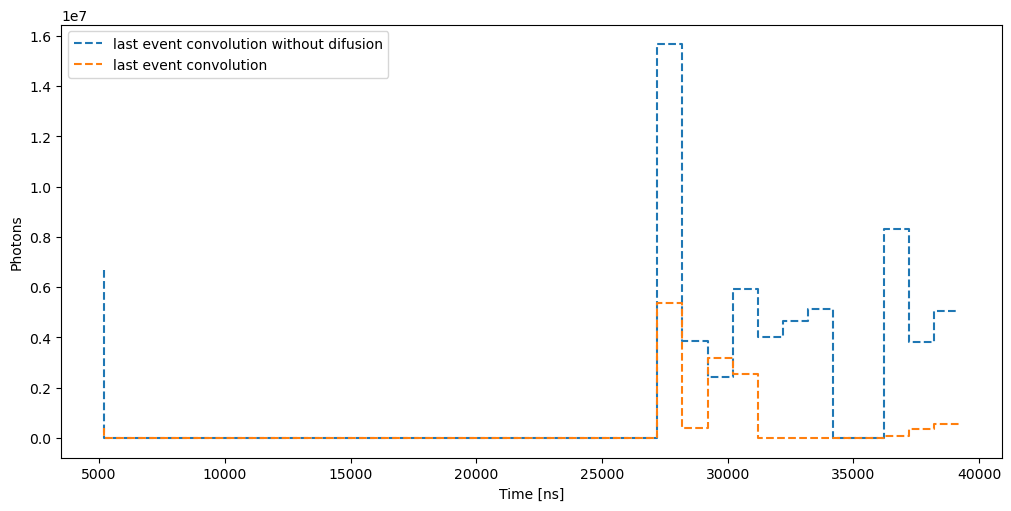

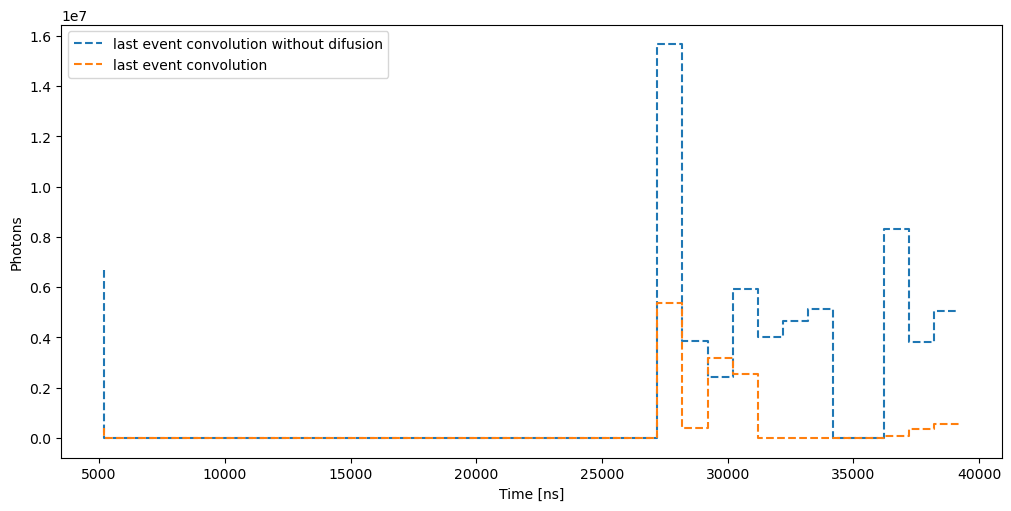

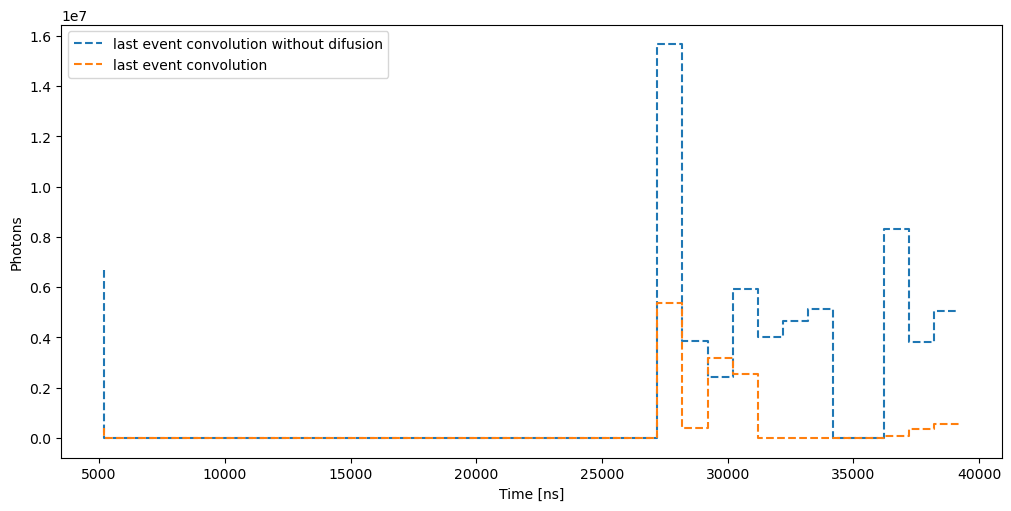

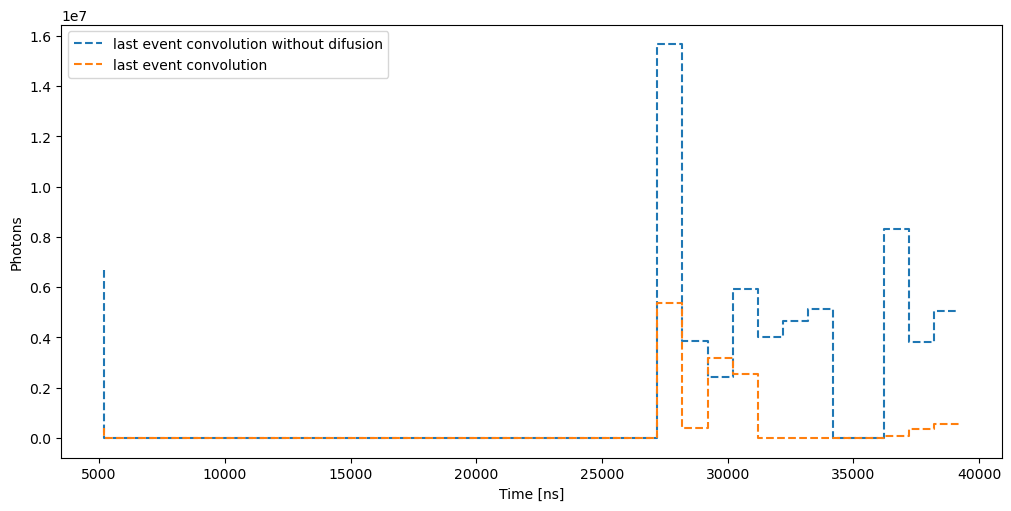

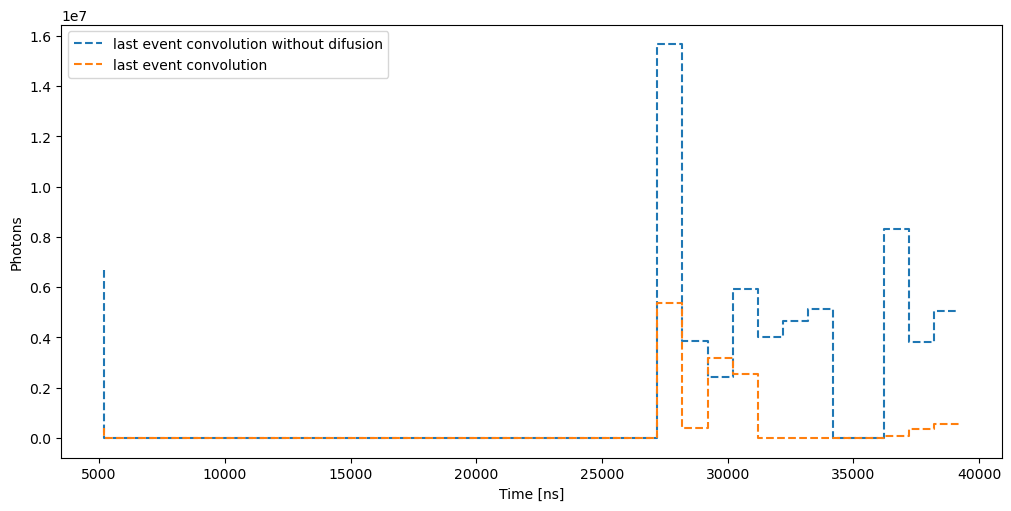

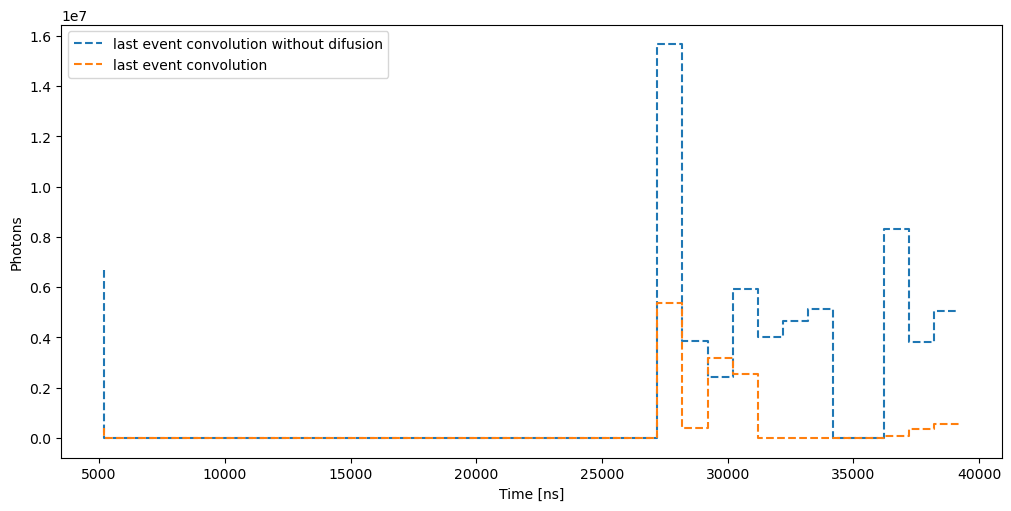

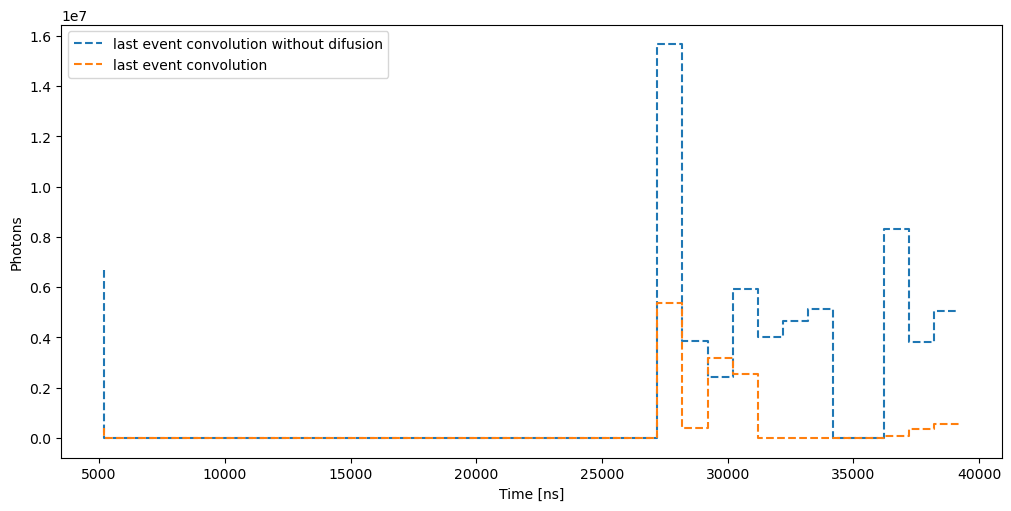

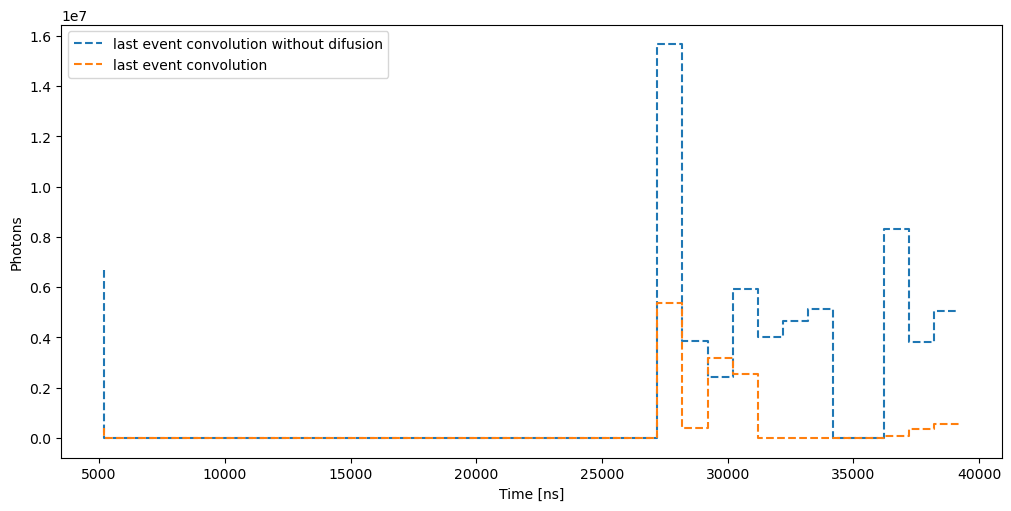

In [284]:
%%timeit
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)
# Define the means, standard deviations, and sizes of the distributions

# s2 = []
# s2_hist = []
max_ev = 2
# max_ev = n_events

s2_hist = np.zeros(shape=(len(EL_gain), max_ev))

for count, EL_value in enumerate(EL_gain):
    
#     s2 = np.zeros(max_ev)

    for ii in range(max_ev):
        
#         if ii%1000 == 0.:
#             print(count, ii)

#         dst_event = dst.loc[(dst['event_id'] == ii), :].copy() # faster

#         hit_time = np.array(dst_event['time']) # [ns]
#         drift_time = np.array(dst_event['drift_time']) # [ns]
#         measurement_time = hit_time + drift_time

#         n_photons = np.array(dst_event['n_ph_'+str(count)])

        drift_time = np.array(drift_time_gg[ii]) # [ns]
        measurement_time = np.array(measurement_time_gg[ii])
        
        n_photons = np.array(n_photons_gg[ii])

        stds = np.array(dst.groupby('event_id')['stds'].apply(list)[ii])
#         stds = np.where(drift_time > 0., difusion_factor/np.sqrt(drift_time), 1e-10)
    #     means = np.zeros(len(stds))
        means =  np.array(measurement_time)
#         sizes = np.array(n_photons, dtype=int)

        # means = np.array([1, 2, 3])
        # stds = np.array([0., 0.2, 2])
        # sizes = np.array([3, 4, 5])

        # Use broadcasting to generate an array of random numbers from normal distributions
        hist_weights = np.zeros_like(measurement_time)
        for hit, t_hit in enumerate(measurement_time):
            gaussian = gauss(measurement_time, n_photons[hit], t_hit, stds[hit])
#             print(len(gaussian[gaussian > 0.]))
            delta = dirac(measurement_time, t_hit)
#             print(delta)
            
#             print(hist_weights)
            hist_weights += convolve(gaussian, delta, mode='same')
#             hist_weights += gaussian
#             print(count, hit, len(hist_weights[hist_weights > 0.]))
            
#         arr = np.random.normal(loc=means[:, np.newaxis], scale=stds[:, np.newaxis], size=(len(means), sizes.max()))

        # Use slicing to extract the subarrays with the desired sizes
#         measurement_time = np.concatenate(np.array([a[:size] for a, size in zip(arr, sizes)], dtype=object))


        if (measurement_time.max() - measurement_time.min()) > dt:
            hist_bins = np.arange(measurement_time.min(), measurement_time.max(), dt)
        else:
            hist_bins = np.array([measurement_time.min(), measurement_time.max()])

        events, bins = np.histogram(measurement_time, hist_bins, weights = hist_weights);
        events2, bins2 = np.histogram(measurement_time, hist_bins, weights = n_photons);
        

#         s2.append(events.max())
#         s2[ii] = events.max()
        s2_hist[count, ii] = events.max()
#         print('s2 = ', s2)
    
#     print('s2 OUT LOOP = ', s2, '\n')
    
#     s2_hist.append(np.array(s2))
    
ax.step(bins2[:-1], events2, '--', label = 'last event convolution without difusion')
ax.step(bins[:-1], events, '--', label = 'last event convolution')

ax.legend(loc = 'best')

ax.set_xlabel('Time [ns]');
ax.set_ylabel('Photons');

# Print the shape of the resulting array
# result

In [203]:
patata = np.zeros_like(measurement_time)
patata += convolve(gaussian, delta, mode='same')
patata

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [184]:
x = measurement_time
mu = t_hit
sigma = stds[hit]

gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
N = np.trapz(gaussian, x=np.sort(x)) or 1.
stats.norm.pdf(np.sort(x), mu, 1e-10) 

array([3.9894228e+09, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [212]:
events.sum() - n_photons.sum()
events2.sum() - n_photons.sum()


-50016000.0

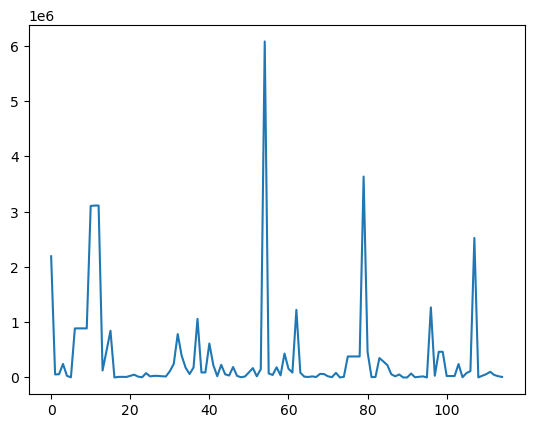

In [168]:
plt.plot(hist_weights)

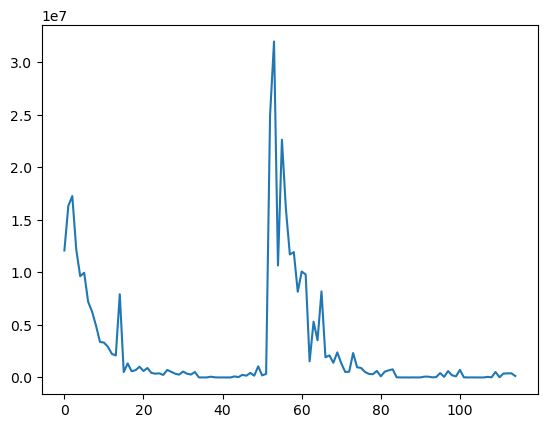

In [152]:
plt.plot(n_photons)

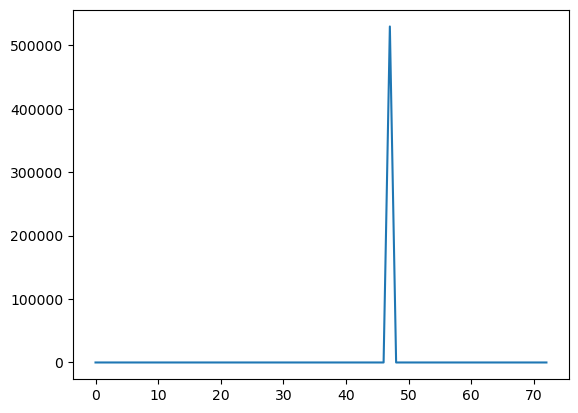

-195648.41412772273

In [136]:
# plt.plot(hist_weights)
# plt.plot(n_photons)
plt.plot(gauss(measurement_time, n_photons[hit], t_hit, stds[hit]))
plt.show()
n_photons[hit] - gauss(measurement_time, n_photons[hit], t_hit, stds[hit]).max()

In [140]:
# yy = gauss(np.sort(measurement_time), 2, np.sort(measurement_time)[50], stds[50])
# yy = gauss(measurement_time, 2, measurement_time[50], stds[50])
# yy = stats.norm.pdf(np.sort(measurement_time), np.sort(measurement_time)[50], stds[50])/(stds[50] * np.sqrt(2*np.pi))
yy = gauss(measurement_time, n_photons[hit], t_hit, stds[hit])

np.trapz(yy, x=np.sort(measurement_time)), n_photons[hit], gauss(measurement_time, n_photons[hit], t_hit, stds[hit]).max()


(334000.00000000006, 334000.0, 529648.4141277227)

In [114]:
np.pi

3.141592653589793

In [109]:
np.sort(measurement_time)

array([1262412.26129102, 1264882.95262747, 1266056.27290767,
       1268485.8640868 , 1268560.20886217, 1268703.15934087,
       1268729.04369958, 1268736.44681216, 1268737.23338865,
       1268782.47854621, 1268794.05259737, 1268832.98877433,
       1268834.30964263, 1268841.59615544, 1268858.6533848 ,
       1268861.4289027 , 1268861.55441413, 1268862.05948591,
       1268862.15407671, 1268863.57263245, 1268864.23457552,
       1268868.30135258, 1268873.28208799, 1268873.87331478,
       1268874.19529845, 1268875.5198483 , 1268918.00382413,
       1268998.51747521, 1269235.15336263, 1269912.02815636,
       1270404.25009462, 1270625.71560022, 1270698.79355669,
       1270839.72313435, 1270864.97320186, 1271167.33885895,
       1271186.55038359, 1271278.89681941, 1271290.47694869,
       1271438.47051023, 1271491.93803217, 1271523.74397764,
       1271545.18459253, 1271610.70465828, 1271615.52848039,
       1271627.2250873 , 1271631.10315916, 1271632.23829988,
       1271632.36437317,

In [102]:
gauss(measurement_time, n_photons[hit], t_hit, stds[hit])
t_hit, measurement_time

(1271632.238299882,
 array([1273495.65388434, 1273895.61623676, 1271290.47694869,
        1271740.49829185, 1270839.72313435, 1270404.25009462,
        1269912.02815636, 1269235.15336263, 1268998.51747521,
        1268485.8640868 , 1268918.00382413, 1268560.20886217,
        1268737.23338865, 1268736.44681216, 1268873.87331478,
        1268782.47854621, 1268834.30964263, 1268703.15934087,
        1268729.04369958, 1268794.05259737, 1268832.98877433,
        1268841.59615544, 1268874.19529845, 1268875.5198483 ,
        1268858.6533848 , 1268873.28208799, 1268861.55441413,
        1268868.30135258, 1268864.23457552, 1268863.57263245,
        1268861.4289027 , 1268862.05948591, 1268862.15407671,
        1273913.6500417 , 1273992.34162011, 1273970.14707328,
        1273962.95917781, 1273960.91010023, 1273958.3250371 ,
        1273962.89651894, 1273966.17538064, 1273964.94588702,
        1273965.00895032, 1275346.00544555, 1273187.31568308,
        1264882.95262747, 1262412.26129102, 126605

In [82]:
tm = np.linspace(0, 10, 1000)

t_hit = tm[20]
t_d_hit = 0.01
n_ph_hit = 10
sigma = difusion_factor/np.sqrt(t_d_hit)

gaussian = gauss(tm, n_ph_hit, t_hit, sigma)
delta = dirac(tm, t_hit)

result = convolve(gaussian, delta, mode='same')

t_hit2 = tm[80]
t_d_hit2 = 0.2
n_ph_hit2 = 7
sigma2 = difusion_factor/np.sqrt(t_d_hit2)

gaussian2 = gauss(tm, n_ph_hit2, t_hit2, sigma2)
delta2 = dirac(tm, t_hit2)

result2 = convolve(gaussian2, delta2, mode='same')

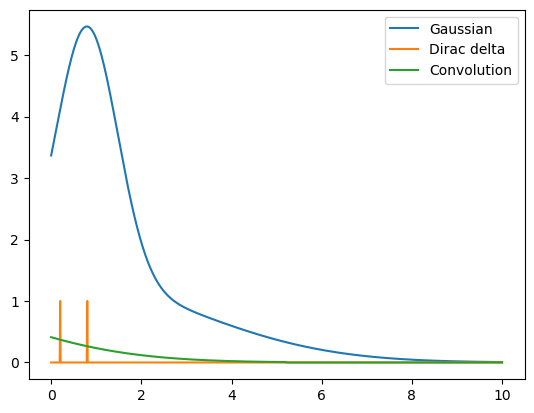

In [83]:
plt.plot(tm, gaussian + gaussian2, label='Gaussian')
plt.plot(tm, delta + delta2, label='Dirac delta')
plt.plot(tm, result + result2, label='Convolution')
plt.legend()
plt.show()

In [14]:
# %%timeit

s2_hist = []

for count, EL_gain_value in enumerate(EL_gain):
    
    s2 = []
    
    # for ii in range(1000):
    for ii in range(n_events):

        dst_event = dst.loc[(dst['event_id'] == ii), :] # faster
    #     dst_event = dst.groupby("event_id").get_group(ii) # slower

        if (dst_event['tot_time'].max() - dst_event['tot_time'].min()) > dt:
            hist_bins = np.arange(dst_event['tot_time'].min(), dst_event['tot_time'].max(), dt)
        else:
            hist_bins = np.array([dst_event['tot_time'].min(), dst_event['tot_time'].max()])

    #     hist_weights = dst_event['n_ph']
        hist_weights = dst_event[str('n_ph_' + str(count))]
        events, bins = np.histogram(dst_event['tot_time'], hist_bins, weights = hist_weights);

        s2.append(events.max())
        
    s2_hist.append(np.array(s2))
    

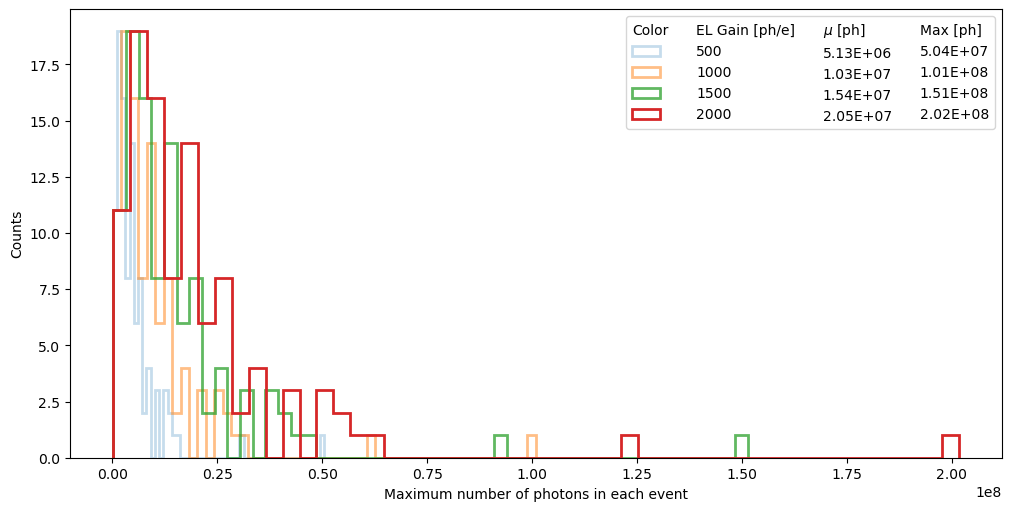

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

#_________plot_settings_________________________________________________


s2_mean = []
s2_max = []

for count, EL_gain_value in enumerate(EL_gain):
# for count, EL_gain_value in enumerate([500]):

    events, bins, bars = ax.hist(s2_hist[count], 50, density=False, 
                                 label='S2 photon distribution', 
                                 histtype='step', 
#                                  range=(-1, 2e2), 
                                 alpha = (0.25 + 0.25*count),
#                                  alpha = (1 - 0.25*count),
                                 lw = 2
                                )

    s2_mean.append(s2_hist[count].mean())
    s2_max.append(s2_hist[count].max())

# ax.set_xlabel('Number of photons in S2');
ax.set_xlabel('Maximum number of photons in each event');
ax.set_ylabel('Counts');

hand, labl = ax.get_legend_handles_labels()
s2_mean = np.array(s2_mean)
s2_max = np.array(s2_max)

# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#Create organized list containing all handles for table. Extra represent empty space
legend_handle = np.concatenate([[extra], hand, 
                                [extra]*(len(hand) + 1),
                                [extra]*(len(hand) + 1),
                                [extra]*(len(hand) + 1)
                               ])

#Define the labels
label_empty = [""]
label_markers = [r"Color"]
label_EL = [r"EL Gain [ph/e]", '%.0f'%(EL_gain[0]), '%.0f'%(EL_gain[1]), '%.0f'%(EL_gain[2]), '%.0f'%(EL_gain[3])]
label_s2mean = [r"$\mu$ [ph]", '%.2E'%(s2_mean[0]), '%.2E'%(s2_mean[1]), '%.2E'%(s2_mean[2]), '%.2E'%(s2_mean[3])]
label_s2max = [r"Max [ph]", '%.2E'%(s2_max[0]), '%.2E'%(s2_max[1]), '%.2E'%(s2_max[2]), '%.2E'%(s2_max[3])]

#organize labels for table construction
legend_labels = np.concatenate([label_markers, label_empty*len(hand), 
                                label_EL, label_s2mean, label_s2max])

#Create legend
ax.legend(legend_handle, legend_labels, 
          loc = 'best', ncol = 4, shadow = False, handletextpad = -2)


In [251]:
len(s2_hist[3])

100